In [257]:
suppressMessages(devtools::install_github("clairbarnes/rwwa"))
suppressMessages(library(rwwa))

varnm <- "tx5x"
rnm <- "kr"
nsamp <- 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# specify arguments for all models
hdwi_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = F)
pr_args <- list(dist = "norm", type = "shift", varnm = "logx", covnm = c("gmst"), lower = T)
tx_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = F)
wind_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = F)
hurs_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = T)
vpd_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = F)

mdl_args <- switch(varnm, "hdwi" = hdwi_args, "pr-fm" = pr_args, "tx5x" = tx_args, "sfcWindmax5x" = wind_args, "vpd5x" = vpd_args)
rp <- switch(varnm, "hdwi" = 100, "tx5x" = 100, "pr-fm" = 5, "sfcWindmax5x" = 5, "vpd5x" = 50)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function to fill infinite probability ratios
infer_infinite <- function(models_in) {
    
    # split out the columns for easier reference
    est <- est_n <- models_in[,1]
    l <- l_n <- models_in[,2]
    u <- u_n <- models_in[,3]
    
    # relabel where infinite best estimate / upper bound occurs
    mnames <- rownames(models_in)
    mnames <- paste0(mnames, c("*","")[is.finite(est)+1])
    mnames <- paste0(mnames, c("*","")[is.finite(u)+1])
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # INFINITE BEST ESTIMATES / UPPER BOUNDS
    # get upper bound where best estimate is infinite
    u_n[!is.finite(u_n)] <- (exp(log(est) + 3 * (log(est) - log(l))))[!is.finite(u_n)]

    # get best estimate, if infinite
    if(any(is.finite(u))) {
        # if any estimated upper bounds are finite, use the maximum upper bound to infer infinite best estimates
        f_upper <- max(u[is.finite(u)])
    } else {
        # otherwise, use the maximum inferred upper bound to infer infinite best estimates
        f_upper <- max(u_n[is.finite(u_n)])
    }
    est_n[!is.finite(est_n)] <- f_upper

    # repeat estimation of upper bound using inferred best estimate
    u_n[!is.finite(u_n)] <- (exp(log(est_n) + 3 * (log(est_n) - log(l))))[!is.finite(u_n)]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # INFINITE LOWER BOUNDS NOT YET IMPLEMENTED

    return(data.frame("est" = est_n, "lower" = l_n, "upper" = u_n, row.names = mnames))   
}

# Check distribution

In [1]:
df <- load_ts("ts-kr/korea-fires_sfcWindmax5x_ERA5land_kr.dat", col.names = c("year", "wind"))

plot(density(df$wind))
pars <- strip(fevd(df$wind))
lines(x <- seq(2,9,0.01), devd(x, loc = pars["location"], scale = pars["scale"], shape = pars["shape"]), col = "blue")

ERROR: Error in load_ts("ts-kr/korea-fires_pr-fm_ERA5land_kr.dat", col.names = c("year", : could not find function "load_ts"


# Trend in obs

In [238]:
rnm <- "kr"
gmst <- read.table("ts-kr/gmst.txt", col.names = c("year", "gmst"))

cov_2025 <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_pi <- cov_2025 - 1.3

for(fnm in list.files("ts-kr", pattern = paste0(varnm,".+ERA5land_",rnm), full.names = T)) {
    if (varnm == "pr-fm") {mtype <- "lnorm"} else {mtype <- mdl_args$dist}
    res_fnm <- gsub(".dat", paste0("_",mtype,".csv"), gsub("ts-kr/korea-fires", "res-obs/res", fnm))
    
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "x"))
        df <- merge(gmst, ts)
        df$logx <- log(df$x)
                
        # get model parameters for selected model
        mdl <- do.call(fit_ns, append(mdl_args, list("data" = df)))
        boot_res <- boot_ci(mdl, cov_f = cov_2025, cov_cf = cov_pi)
        write.csv(boot_res, res_fnm)
    }
}

In [240]:
# compile results
obs_res <- t(sapply(list.files("res-obs", pattern = paste0("res_",varnm,".+",rnm,"_",mtype), full.names = T), function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
}))
# rownames(obs_res) <- sapply(strsplit(rownames(obs_res), "_"), "[", 2)
rownames(obs_res) <- "ERA5land"
write.csv(obs_res, paste0("res-obs_",varnm,"_",rnm,".csv"))

## Results with RP100

In [52]:
rnm <- "kr"
gmst <- read.table("ts-kr/gmst.txt", col.names = c("year", "gmst"))

cov_2025 <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_pi <- cov_2025 - 1.3

for(fnm in list.files("ts-kr", pattern = paste0(varnm,".+ERA5land_",rnm), full.names = T)) {
    res_fnm <- gsub(".dat", "_gev.csv", gsub("ts-kr/korea-fires", "res-obs/res-rp100", fnm))
    
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "x"))
        df <- merge(gmst, ts)
        df$logx <- log(df$x)
                
        # get model parameters for selected model
        mdl <- do.call(fit_ns, append(mdl_args, list("data" = df)))
        rl100 <- eff_return_level(mdl1, rp = 100, fixed_cov = cov_2025)
        mdl$ev <- rl100
        
        boot_res <- boot_ci(mdl, cov_f = cov_2025, cov_cf = cov_pi)
        write.csv(boot_res, res_fnm)
    }
}

In [125]:
# compile results
obs_res <- t(sapply(list.files("res-obs", pattern = paste0("res-rp100_",varnm,".+",rnm), full.names = T), function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
}))

# rownames(obs_res) <- sapply(strsplit(rownames(obs_res), "_"), "[", 2)
rownames(obs_res) <- "ERA5land"
write.csv(obs_res, paste0("res-rp100_",varnm,"_",rnm,".csv"))

## Truncated obs

In [84]:
rnm <- "kr"
gmst <- read.table("ts-kr/gmst.txt", col.names = c("year", "gmst"))

cov_2025 <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_pi <- cov_2025 - 1.3

for(fnm in list.files("ts-kr", pattern = paste0(varnm,".+ERA5land_",rnm), full.names = T)) {
    res_fnm <- gsub(".dat", "_gev.csv", gsub("ts-kr/korea-fires", "res-obs/res-1970", fnm))
    
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "x"))
        ts <- ts[ts$year >= 1970,]
        df <- merge(gmst, ts)
        df$logx <- log(df$x)
                
        # get model parameters for selected model
        mdl <- do.call(fit_ns, append(mdl_args, list("data" = df)))
        boot_res <- boot_ci(mdl, cov_f = cov_2025, cov_cf = cov_pi)
        write.csv(boot_res, res_fnm)
    }
}

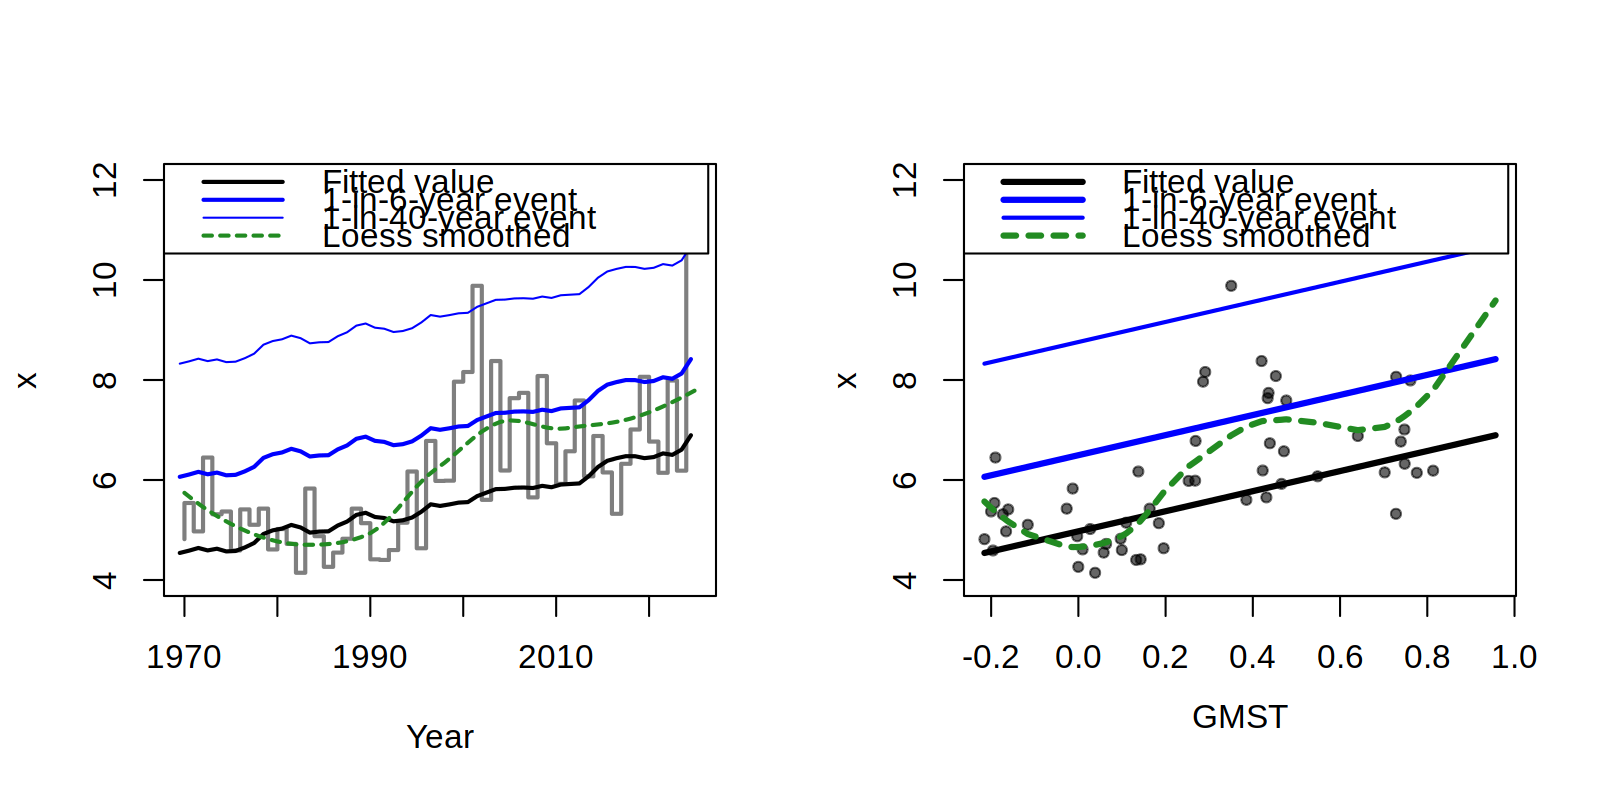

In [46]:
prep_window(c(1,2))
plot_trend(mdl, add_loess = T)
plot_covtrend(mdl, "gmst", add_loess = T)

# Trends in stations

In [258]:
for(fnm in list.files("ts-kr", pattern = paste0(varnm,"[.+]?_stn.+",rnm), full.names = T)) {
    res_fnm <- gsub(".dat", "_gev.csv", gsub("ts-kr/korea-fires", "res-obs/res", fnm))
    
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "x"))
        df <- merge(gmst, ts)
        df$logx <- log(df$x)
        df <- df[!is.na(df$x),]
                
        # get model parameters for selected model
        mdl <- do.call(fit_ns, append(mdl_args, list("data" = df)))
        boot_res <- boot_ci(mdl, cov_f = cov_2025, cov_cf = cov_pi)
        write.csv(boot_res, res_fnm)
    }
}

In [86]:
list.files("ts-kr", pattern = paste0(varnm,"[.+]?_stn.+",rnm), full.names = T)

[1] "ts-kr/korea-fires_vpd5x_stn-130_kr.dat"
 [2] "ts-kr/korea-fires_vpd5x_stn-136_kr.dat"
 [3] "ts-kr/korea-fires_vpd5x_stn-138_kr.dat"
 [4] "ts-kr/korea-fires_vpd5x_stn-271_kr.dat"
 [5] "ts-kr/korea-fires_vpd5x_stn-272_kr.dat"
 [6] "ts-kr/korea-fires_vpd5x_stn-273_kr.dat"
 [7] "ts-kr/korea-fires_vpd5x_stn-277_kr.dat"
 [8] "ts-kr/korea-fires_vpd5x_stn-278_kr.dat"
 [9] "ts-kr/korea-fires_vpd5x_stn-279_kr.dat"
[10] "ts-kr/korea-fires_vpd5x_stn-281_kr.dat"

In [87]:
# compile results
stn_res <- t(sapply(list.files("res-obs", pattern = paste0(varnm,"[.+]?_stn.+",rnm), full.names = T), function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
}))
rownames(stn_res) <- sapply(strsplit(rownames(stn_res),"_"), "[", 3)
write.csv(stn_res, paste0("res-stn_",varnm,"_",rnm,".csv"))

# Trend in climate models

In [281]:
# highresmip & cmip6
for (fnm in list.files("ts-kr", pattern = paste0(varnm,".+",rnm), full.names = T)) {
        
    res_fnm <- gsub("ts", "res", gsub(".dat", ".csv", fnm))
    if (file.exists(res_fnm)) next
    
    gcm <- paste0(strsplit(fnm, "_")[[1]][4:5], collapse = "_")    
    
    # check if GMST time series exists
    if(grepl("cmip6", fnm)) {
        gmst_fnm <- list.files("ts-cmip6", pattern = paste0("SGSAT.+", gcm), full.names = T)
    } else if(grepl("highres", fnm)) {
        gmst_fnm <- list.files("ts-highresmip", pattern = paste0("GSAT.+", gcm), full.names = T)
    } else if(grepl("25km", fnm)) {
        gcm <- "AWI-CM3-25km"
        gmst_fnm <- list.files("ts-kr", pattern = paste0("gmst_", gcm), full.names = T)
    } else {
        next
    }
    
    print(gcm)
    if(length(gmst_fnm) == 0) next
    
    # load all the data
    ts <- load_ts(fnm, col.names = c("year", "x"))
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    df <- merge(gmst, ts)
    df$logx <- log(df$x)
    
    # pick up model to be fitted depending on variable
    mdl <- do.call(fit_ns, append(mdl_args, list("data" = df[df$year <= 2070,])))
        
    # use model's 2025 GMST to define factual climate        
    cov_now <- df[df$year == 2025,"gmst",drop = F]
    cov_hist <- cov_now - 1.3
    cov_fut <- cov_now + 1.3

    # bootstrap results
    res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut, y_now = 2025, y_start = 1940, y_fut = 2070, nsamp = nsamp)
    res <- cbind(res, data.frame("ystart" = min(df$year), "yend" = max(df$year)))
    write.csv(res, res_fnm)

    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res-kr/", "mdl-eval-kr/rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub(".csv", "", fnm)))
        }; dev.off()
    }
}

[1] "CAMS-CSM1-0_r2i1p1f1"
[1] "CanESM5_r10i1p1f1"
[1] "CNRM-CM6-1-HR_r1i1p1f2"
[1] "CNRM-ESM2-1_r1i1p1f2"
[1] "HadGEM3-GC31-MM_r1i1p1f3"
[1] "UKESM1-0-LL_r14i1p1f2"
[1] "UKESM1-0-LL_r1i1p1f2"
[1] "CNRM-CM6-1_r1i1p1f2"
[1] "CNRM-CM6-1-HR_r1i1p1f2"
[1] "EC-Earth3P_r1i1p1f1"
[1] "EC-Earth3P-HR_r1i1p1f1"
[1] "HadGEM3-GC31-HM_r1i1p1f1"
[1] "HadGEM3-GC31-LM_r1i14p1f1"
[1] "HadGEM3-GC31-MM_r1i1p1f1"
[1] "MPI-ESM1-2-HR_r1i1p1f1"
[1] "MPI-ESM1-2-XR_r1i1p1f1"


In [282]:
# compile results
res <- t(sapply(list.files("res-kr", pattern = paste0(varnm,".+",rnm), full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) gsub("_kr.+", "", paste0(strsplit(rnm,"_")[[1]][3:5], collapse = "_")))
write.csv(res, paste0("res-models_",varnm,"_",rnm,".csv"))


## AM2.5 / FLOR

In [149]:
for (fnm in list.files("ts-princeton", pattern = paste0(varnm,".+kr"), full.names = T)) {
    res_fnm <- gsub("ts", "res", gsub(".dat", ".csv", fnm))
    if (file.exists(res_fnm)) next
    
    gcm <- paste0(strsplit(fnm, "_")[[1]][3:4], collapse = "_")

    # check that GMST time series exists
    gmst_fnm <- list.files("ts-princeton", pattern = paste0("gmst_", gcm), full.names = T)
    if(length(gmst_fnm) == 0) next
    

    # load all the data
    ts <- load_ts(fnm, col.names = c("year", "x"))
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    df <- merge(gmst, ts)
    
    mdl <- do.call(fit_ns, append(mdl_args, list("data" = df)))
    
    # use model's 2025 GMST to define factual climate        
    cov_now <- df[df$year == 2025,"gmst",drop = F]
    cov_hist <- cov_now - 1.3
    cov_fut <- cov_now + 1.3

    # bootstrap results
    res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut, y_now = 2025, y_start = 1940, y_fut = 2070, nsamp = nsamp)
    res <- cbind(res, data.frame("ystart" = min(df$year), "yend" = max(df$year)))
    write.csv(res, res_fnm)
    
    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res-princeton/", "mdl-eval-kr/rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub(".csv", "", fnm)))
        }; dev.off()
    }
}

In [150]:
res <- t(sapply(list.files("res-princeton", pattern = paste0(varnm,".+kr"), full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) paste0(strsplit(rnm,"_")[[1]][3:4], collapse = "_"))
write.csv(res, paste0("res-princeton_",varnm,"_kr.csv"))

# Synthesis of initial results

In [362]:
varnm <- "pr-fm"
stype <- "rel"
rnm <- "kr"

In [363]:
stitle <- paste0(switch(stype, "abs" = "Change in ", "rel" = "% change in "), toupper(varnm))

dI_xlim <- switch(paste0(varnm,stype), "hdwiabs" = c(-4,6), "hdwirel" = c(-25,50), "tx5xabs" = c(-1,7), "pr-fmrel" = c(-50,150), "pr-fmabs" = c(-25,80))
PR_xlim <- switch(varnm, "hdwi" = c(1e-3,1e5), "tx5x" = c(0.1,100000))

In [364]:
# res_obs <- read.csv(paste0("res-rp100_",varnm,"_",rnm,".csv"), row.names = "X")
res_obs <- read.csv(paste0("res-obs_",varnm,"_",rnm,".csv"), row.names = "X")
if (varnm == "hdwi") res_obs <- res_obs[2,]

rownames(res_obs) <- "ERA5land"

res_models <- read.csv(list.files(pattern = paste0("res-models_",varnm,".+",rnm,".csv")), row.names = "X")
res_models <- res_models[res_models[,"include"] == "Y",]

res_princeton <- read.csv(paste0("res-princeton_",varnm,"_kr.csv"), row.names = "X")

In [365]:
am25_dI_attr <- synthesis(obs_in = NA,
                          models_in = infer_infinite(res_princeton[grepl("AM2", rownames(res_princeton)), grepl(paste0("attr_dI.",stype), colnames(res_princeton))]),
                          synth_type = stype)

am25_PR_attr <- synthesis(obs_in = NA,
                          models_in = infer_infinite(res_princeton[grepl("AM2", rownames(res_princeton)), grepl("attr_PR", colnames(res_princeton))]),
                          synth_type = "PR")

am25_dI_proj <- synthesis(obs_in = NA,
                          models_in = infer_infinite(res_princeton[grepl("AM2", rownames(res_princeton)), grepl(paste0("proj_dI.",stype), colnames(res_princeton))]),
                          synth_type = stype)

am25_PR_proj <- synthesis(obs_in = NA,
                          models_in = infer_infinite(res_princeton[grepl("AM2", rownames(res_princeton)), grepl("proj_PR", colnames(res_princeton))]),
                          synth_type = "PR")

Warning message in log(l):
“NaNs produced”
Warning message in log(l):
“NaNs produced”


In [366]:
flor_dI_attr <- synthesis(obs_in = NA,
                          models_in = infer_infinite(res_princeton[grepl("FLOR", rownames(res_princeton)), grepl(paste0("attr_dI.",stype), colnames(res_princeton))]),
                          synth_type = stype)

flor_PR_attr <- synthesis(obs_in = NA,
                          models_in = infer_infinite(res_princeton[grepl("FLOR", rownames(res_princeton)), grepl("attr_PR", colnames(res_princeton))]),
                          synth_type = "PR")

flor_dI_proj <- synthesis(obs_in = NA,
                          models_in = infer_infinite(res_princeton[grepl("FLOR", rownames(res_princeton)), grepl(paste0("proj_dI.",stype), colnames(res_princeton))]),
                          synth_type = stype)

flor_PR_proj <- synthesis(obs_in = NA,
                          models_in = infer_infinite(res_princeton[grepl("FLOR", rownames(res_princeton)), grepl("proj_PR", colnames(res_princeton))]),
                          synth_type = "PR")

Warning message in log(est):
“NaNs produced”
Warning message in log(est):
“NaNs produced”
Warning message in log(l):
“NaNs produced”
Warning message in log(est_n):
“NaNs produced”
Warning message in log(est_n):
“NaNs produced”
Warning message in log(l):
“NaNs produced”
Warning message in log(l):
“NaNs produced”
Warning message in log(l):
“NaNs produced”


In [367]:
write.csv(flor_dI_attr$df, paste0("synth/synth-flor_",varnm,"_",rnm,"_dI-",stype,"_attr.csv"), row.names = F)
write.csv(flor_PR_attr$df, paste0("synth/synth-flor_",varnm,"_",rnm,"_PR_attr.csv"), row.names = F)
write.csv(flor_dI_proj$df, paste0("synth/synth-flor_",varnm,"_",rnm,"_dI-",stype,"_proj.csv"), row.names = F)
write.csv(flor_PR_proj$df, paste0("synth/synth-flor_",varnm,"_",rnm,"_PR_proj.csv"), row.names = F)

write.csv(am25_dI_attr$df, paste0("synth/synth-am25_",varnm,"_",rnm,"_dI-",stype,"_attr.csv"), row.names = F)
write.csv(am25_PR_attr$df, paste0("synth/synth-am25_",varnm,"_",rnm,"_PR_attr.csv"), row.names = F)
write.csv(am25_dI_proj$df, paste0("synth/synth-am25_",varnm,"_",rnm,"_dI-",stype,"_proj.csv"), row.names = F)
write.csv(am25_PR_proj$df, paste0("synth/synth-am25_",varnm,"_",rnm,"_PR_proj.csv"), row.names = F)

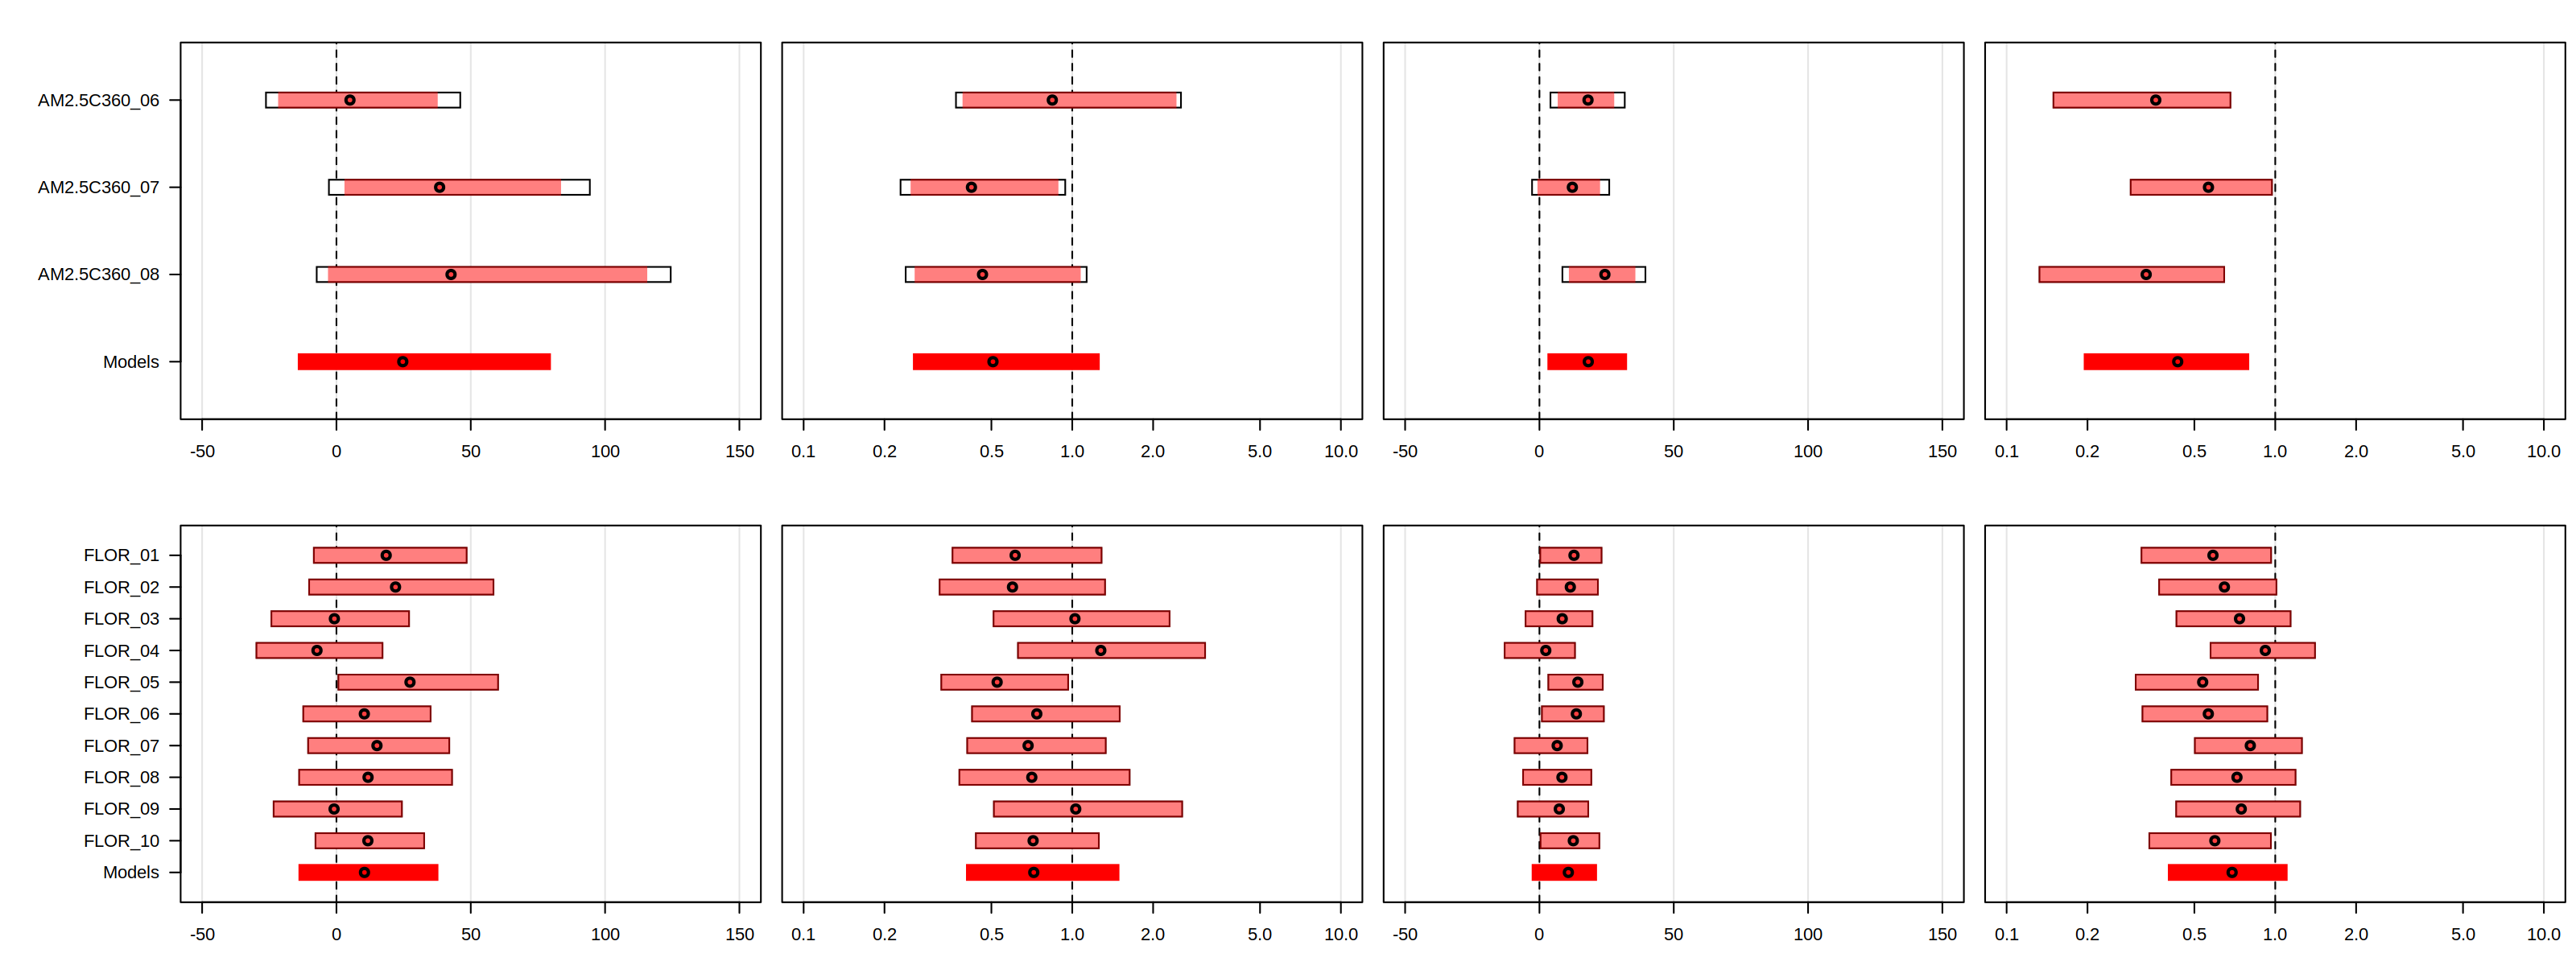

In [368]:
prep_window(c(2,4), h = 3, oma = c(0,8,0,0), mar = c(3,0.5,2,0.5))

plot_synthesis(am25_dI_attr, xlim = dI_xlim)
plot_synthesis(am25_PR_attr, hide_labels = T, xlim = PR_xlim)
plot_synthesis(am25_dI_proj, hide_labels = T, xlim = dI_xlim)
plot_synthesis(am25_PR_proj, hide_labels = T, xlim = PR_xlim)

plot_synthesis(flor_dI_attr, xlim = dI_xlim)
plot_synthesis(flor_PR_attr, hide_labels = T, xlim = PR_xlim)
plot_synthesis(flor_dI_proj, hide_labels = T, xlim = dI_xlim)
plot_synthesis(flor_PR_proj, hide_labels = T, xlim = PR_xlim)

In [369]:
res_flor <- data.frame(c(setNames(flor_PR_attr$df[nrow(flor_PR_attr$df),3:5], paste0("attr_PR_",c("est", "lower", "upper"))),
                         setNames(flor_dI_attr$df[nrow(flor_dI_attr$df),3:5], paste0("attr_dI.",stype, "_",c("est", "lower", "upper"))),
                         setNames(flor_PR_proj$df[nrow(flor_PR_proj$df),3:5], paste0("proj_PR_",c("est", "lower", "upper"))),
                         setNames(flor_dI_proj$df[nrow(flor_dI_proj$df),3:5], paste0("proj_dI.",stype, "_",c("est", "lower", "upper")))), 
                       row.names = "FLOR (10)")

In [370]:
res_am25 <- data.frame(c(setNames(am25_PR_attr$df[nrow(am25_PR_attr$df),3:5], paste0("attr_PR_",c("est", "lower", "upper"))),
                         setNames(am25_dI_attr$df[nrow(am25_dI_attr$df),3:5], paste0("attr_dI.",stype, "_",c("est", "lower", "upper"))),
                         setNames(am25_PR_proj$df[nrow(am25_PR_proj$df),3:5], paste0("proj_PR_",c("est", "lower", "upper"))),
                         setNames(am25_dI_proj$df[nrow(am25_dI_proj$df),3:5], paste0("proj_dI.",stype, "_",c("est", "lower", "upper")))), 
                       row.names = "AM2.5C360 (3)")

In [371]:
res_allmodels <- rbind(res_models[,colnames(res_flor)], res_flor, res_am25)

In [372]:
synth_dI_attr <- synthesis(obs_in = res_obs[,grepl(stype, colnames(res_obs)),drop = F],
                           models_in = res_allmodels[,grepl(paste0("attr_dI.",stype), colnames(res_allmodels))],
                           synth_type = stype)

synth_PR_attr <- synthesis(obs_in = infer_infinite(res_obs[,grepl("PR", colnames(res_obs)),drop = F]),
                           models_in = infer_infinite(res_allmodels[,grepl("attr_PR", colnames(res_allmodels))]),
                           synth_type = "PR")

synth_dI_proj <- synthesis(obs_in = NA,
                           models_in = res_allmodels[,grepl(paste0("proj_dI.",stype), colnames(res_allmodels))],
                           synth_type = stype)

synth_PR_proj <- synthesis(obs_in = NA,
                           models_in = infer_infinite(res_allmodels[,grepl("proj_PR", colnames(res_allmodels))]),
                           synth_type = "PR")

# rename models with infinite values
synth_dI_proj$df$model <- synth_PR_proj$df$model 
synth_dI_attr$df$model <- synth_PR_attr$df$model


In [373]:
write.csv(synth_dI_attr$df, paste0("synth/synth_",varnm,"_",rnm,"_dI-",stype,"_attr.csv"), row.names = F)
write.csv(synth_PR_attr$df, paste0("synth/synth_",varnm,"_",rnm,"_PR_attr.csv"), row.names = F)
write.csv(synth_dI_proj$df, paste0("synth/synth_",varnm,"_",rnm,"_dI-",stype,"_proj.csv"), row.names = F)
write.csv(synth_PR_proj$df, paste0("synth/synth_",varnm,"_",rnm,"_PR_proj.csv"), row.names = F)

In [374]:
png(paste0("fig/synth_",varnm,"_",rnm,"_attr-",stype,".png"), width = 3 * 240); {
    prep_window(c(1,2), h = 8, w = 5, oma = c(0,18,0,0), mar = c(3,0.5,2,0.5))

    plot_synthesis(synth_dI_attr, main = stitle, xlim = dI_xlim)
    plot_synthesis(synth_PR_attr, hide_labels = T, main = "Change in likelihood", xlim = PR_xlim)
}; dev.off()

png 
  2

In [375]:
png(paste0("fig/synth_",varnm,"_",rnm,"_proj-",stype,".png"), width = 3 * 240); {
    prep_window(c(1,2), h = 8, oma = c(0,18,0,0), mar = c(3,0.5,2,0.5))

    plot_synthesis(synth_dI_proj, main = stitle, add_space = F, xlim = dI_xlim)
    plot_synthesis(synth_PR_proj, hide_labels = T, main = "Change in likelihood", add_space = F, xlim = PR_xlim)
}; dev.off()

png 
  2

## Synthesis of stations

In [347]:
res_stn <- read.csv("res-stn_hdwi_kr.csv", row.names = "X")
res_stn <- res_stn[!rownames(res_stn) %in% c("stn-271"),]

In [159]:
res_vpd <- read.csv("res-stn_vpd_kr.csv", row.names = "X")

Warning message in file(file, "rt"):
“cannot open file 'res-stn_vpd_kr.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [69]:
stn_dI_attr <- synthesis(obs_in = NA,
                          models_in = infer_infinite(res_stn[, grepl(paste0("dI.",stype), colnames(res_stn))]),
                          synth_type = stype)
stn_PR_attr <- synthesis(obs_in = NA,
                           models_in = infer_infinite(res_stn[, grepl("PR", colnames(res_stn))]),
                           synth_type = "PR")

stn_names <- read.csv("station-metadata.csv", row.names = "X")[substr(stn_dI_attr$df$model,5,8),"stn_name"]
stn_names[length(stn_names)] <- "All stations"
stn_dI_attr$df$model <- stn_PR_attr$df$model <- stn_names

In [98]:
write.csv(stn_dI_attr$df, paste0("synth/stn-synth_hdwi_dI_attr.csv"), row.names = F)
write.csv(stn_PR_attr$df, paste0("synth/stn-synth_hdwi_PR_attr.csv"), row.names = F)

In [97]:
stn_dI_attr$df$est[stn_dI_attr$df$lower > 0]

[1] 11.02708 20.06466 21.70057 50.81569 19.21108 19.58421

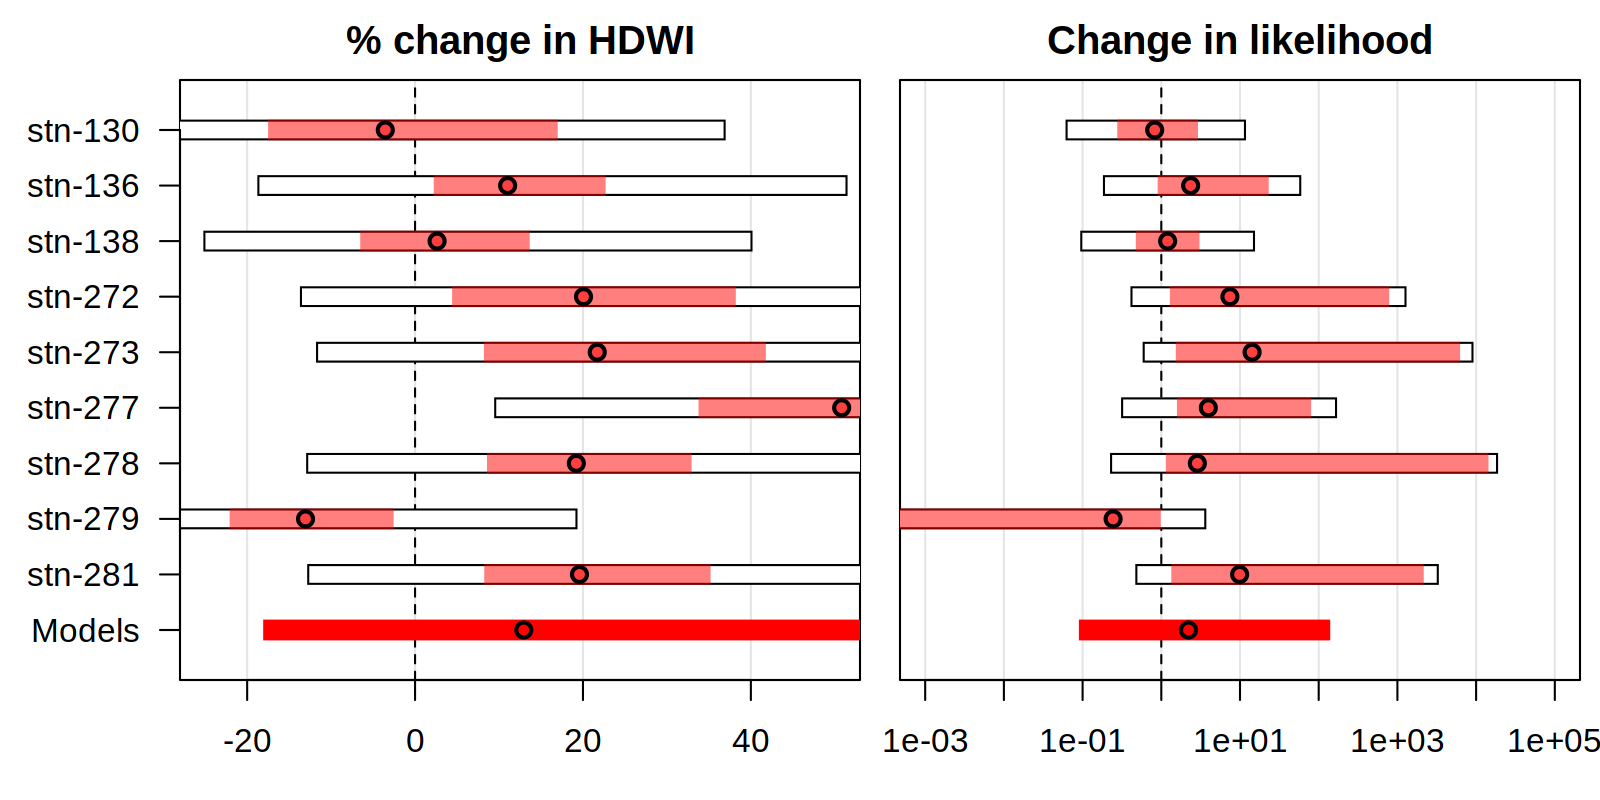

In [29]:
prep_window(c(1,2), h = 4, oma = c(0,4,0,0), mar = c(3,0.5,2,0.5))

plot_synthesis(stn_dI_attr, main = stitle, add_space = F, xlim = dI_xlim)
plot_synthesis(stn_PR_attr, hide_labels = T, main = "Change in likelihood", add_space = F, xlim = PR_xlim)

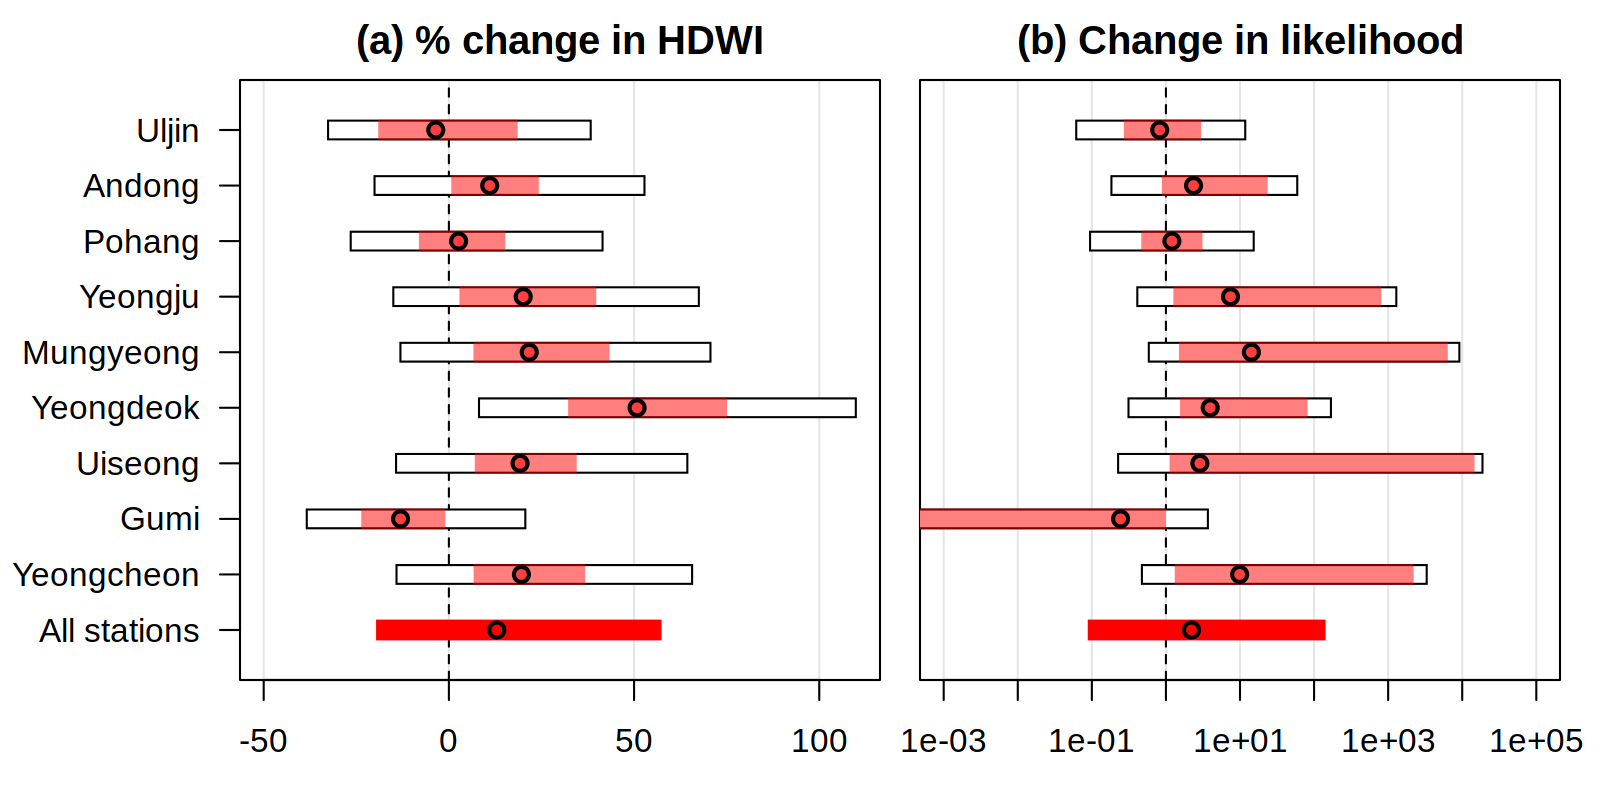

In [74]:
# png("fig/station-synth.png", height = 360, width = 360*2.1); {
    prep_window(c(1,2), h = 4, oma = c(0,6,0,0), mar = c(3,0,2,1))

    plot_synthesis(stn_dI_attr, main = "(a) % change in HDWI", add_space = F, xlim = c(-50,110))
    plot_synthesis(stn_PR_attr, hide_labels = T, main = "(b) Change in likelihood", add_space = F, xlim = PR_xlim)
# }; dev.off()

# Fit trend to gridded data

In [35]:
rnm <- "kr"
gmst <- read.table("ts-kr/gmst.txt", col.names = c("year", "gmst"))

cov_2025 <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_pi <- cov_2025 - 1.3

In [39]:
for (varnm in c("hdwi", "pr", "tasmax", "sfcWindmax", "hursmin", "vpdmax")[4:6]) {

mdl_args <- switch(varnm, "hdwi" = hdwi_args, "pr" = pr_args, "tasmax" = tx_args, "sfcWindmax" = wind_args, "hursmin" = hurs_args, "vpdmax" = vpd_args)

fnm <- paste0("flattened/",varnm,"-flattened_era5land.csv")
res_fnm <- paste0("flattened/",varnm,"-res_era5land.csv")

df <- read.csv(fnm, skip = 3, header = F)
colnames(df)[1] <- "year"
df <- merge(gmst, df)

# fit nonstationary model to all columns
models <- sapply(colnames(df)[grepl("V", colnames(df))], function(cnm) {
    df_c <- df[,c("year", "gmst", cnm)]
    df_c <- df_c[!is.na(df_c[,cnm]),]
    df_c <- setNames(df_c, c("year", "gmst", "x"))
    tryCatch({
        do.call(fit_ns, append(mdl_args, list("data" = df_c)))
    }, error = function(cond) { return(NULL) })
}, simplify = F)

# get all model results & save as .csv to be reconstructed & plotted in python
fitted_res <- sapply(models, function(mdl) {
    if(!is.null(unlist(mdl)[1])) {
        mdl_ests(mdl, cov_f = cov_2025, cov_cf = cov_pi)
    } else {
        rep(NA, 11)
    }})

write.csv(fitted_res, res_fnm)
}